# **Building A CNN with Tensorflow**

https://www.tensorflow.org/

## In this assignment, I will be using various useful imports to develop a CNN model that will be able to classify MNIST data as provided.

## Imports

In [1]:
import os

from utils import timer

import idx2numpy                                            # type: ignore
import numpy as np
from mlxtend.data import loadlocal_mnist                    # type: ignore
from numpy import mean
from numpy import std
from matplotlib import pyplot as plt
from sklearn.model_selection import KFold
from tensorflow.keras.utils import to_categorical           # type: ignore
from tensorflow.keras.models import Sequential              # type: ignore
from tensorflow.keras.layers import Conv2D                  # type: ignore
from tensorflow.keras.layers import MaxPooling2D            # type: ignore
from tensorflow.keras.layers import Dense                   # type: ignore
from tensorflow.keras.layers import Flatten                 # type: ignore
from tensorflow.keras.optimizers import SGD                 # type: ignore
from tensorflow.keras.layers import BatchNormalization		# type: ignore

## Processing & PreProcessing The Data

Before I can do any work on the datasets, they need to be converted to a more workable form than byte-encoding. To do this, I made use of the python package `idx2numpy` whose method `convert_from_file`, takes a file path and returns a numpy array. Once this is done, we can begin doing all of the necessary preprocessing.

!!!!! Make sure you have all four mnist files in a subdirectory: `./data/`

In [21]:
# all local paths are for mac
train_img_file = f'{os.getcwd()}/data/emnist-digits-train-images-idx3-ubyte'
test_img_file = f'{os.getcwd()}/data/emnist-digits-test-images-idx3-ubyte'
train_label_file = f'{os.getcwd()}/data/emnist-digits-train-labels-idx1-ubyte'
test_label_file = f'{os.getcwd()}/data/emnist-digits-test-labels-idx1-ubyte'

# convert to numpy arrays
X_train = idx2numpy.convert_from_file(train_img_file)
y_train = idx2numpy.convert_from_file(train_label_file)
X_test = idx2numpy.convert_from_file(test_img_file)
y_test = idx2numpy.convert_from_file(test_label_file)

Before I move on to actually loading and reshaping the data set, lets visualize a small sample.

I will look at the first 9 numbers.

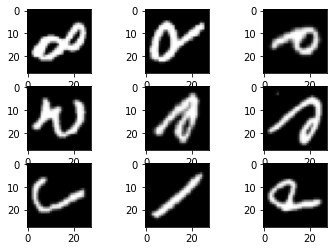

In [10]:
for i in range(9): 
    plt.subplot(330 + 1 + i) 
    plt.imshow(X_train[i], cmap=plt.get_cmap('gray'))
plt.show()

The numbers are rotated multiple times but the labels are still accurate and we can still generally tell what the numbers are. This step is insignificant as the orientation of the pixels is not impactful to tensorflow's learning in a meaningful way.

The below code is a function that serves to do two things to our data set. First, it reshapes all images (numpy matricies) to be 28 x 28 squares with a single color channel: an assumption I'm able to make because some of the features of the dataset are known to us. Then it executes one hot encoding on our labels using the keras-provided `to_categorical` method.

In [3]:
@timer
def load_dataset():
    # reshape dataset to have a single channel
    trainX = X_train.reshape((X_train.shape[0], 28, 28, 1))
    testX = X_train.reshape((X_train.shape[0], 28, 28, 1))
    
    # one hot encode target values
    trainY = to_categorical(y_train)
    testY = to_categorical(y_test)
    return (trainX, trainY, testX, testY)

Now, I came to my first hiccup in the form of this conundrum: I do not know the best way to scale the pixel values for modeling, but I know that some scaling will be required. Therefore, I'll start by normalizing the pixel values of grayscale images, e.g. rescale them to the range [0,1]. This involves first converting the data type from unsigned integers to floats, then dividing the pixel values by the maximum value.

In [11]:
@timer
# scale pixels
def prep_pixels(train, test):
    train_norm = train.astype('float32')
    test_norm = test.astype('float32')
    train_norm = train_norm / 255.0
    test_norm = test_norm / 255.0
    return train_norm, test_norm

This function will be used in the driver of this model as it is supposed to work per iteration on multiple sets of data.

## Defining & Building The Model

Finally, I can define a baseline convolutional neural network model for the problem.

The model will need two main aspects: the feature extraction front end comprised of convolutional and pooling layers, and the classifier backend that will make the actual prediction.

For the convolutional front-end, I'll start with a single convolutional layer with a small filter size (3,3) and a modest number of filters (32) followed by a max pooling layer. The filter maps can then be flattened to provide features to the classifier.

Given that the problem is a multi-class classification task, we know that we will require an output layer with 10 nodes in order to predict the probability distribution of an image belonging to each of the 10 classes. This will also require the use of a softmax activation function. Between the feature extractor and the output layer I'll add a dense layer with 100 nodes.

All layers will use the ReLU activation function and the He weight initialization scheme.

We will use a conservative configuration for the stochastic gradient descent optimizer with a learning rate of 0.01 and a momentum of 0.9. The categorical cross-entropy loss function will be optimized, suitable for multi-class classification, and we will monitor the classification accuracy metric, which is appropriate given we have the same number of examples in each of the 10 classes.

In [8]:
@timer
# define cnn model
def define_model():
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', input_shape=(28, 28, 1)))
    model.add(MaxPooling2D((2, 2)))
    model.add(Flatten())
    model.add(Dense(100, activation='relu', kernel_initializer='he_uniform'))
    model.add(Dense(10, activation='softmax'))
    # compile model
    opt = SGD(learning_rate=0.01, momentum=0.9)
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model

## Initially Evaluating The Model

The model will be evaluated using five-fold cross-validation. I chose the value of k=5 to provide a baseline for both repeated evaluation and to not be so large as to require a long running time (though this is pennies really at our dataset size, at larger sizes with more folds this consideration needs to be taken seriously). Each test set will be 20% of the training dataset.

The training dataset is shuffled prior to being split, and the sample shuffling is performed each time, so that any model we evaluate will have the same train and test datasets in each fold, providing an apples-to-apples comparison between models.

We will train the baseline model for a modest 10 training epochs with a default batch size of 32 examples. The test set for each fold will be used to evaluate the model both during each epoch of the training run, so that we can later create learning curves, and at the end of the run, so that we can estimate the performance of the model. As such, we will keep track of the resulting history from each run, as well as the classification accuracy of the fold.

**NOTE!! Depending on your system's specifications and components, tensorflow will operate at different rates - especially for a problem of this size. Refer to the following measurement (up to date as of 4-17-22) to inform your wait time.**

ON:
MacBook Pro (13-inch, 2020, 1.4 GHz Quad-Core Intel Core i5, 16 GB 2133MHz LPDDR3 RAM)

IT TOOK:
~26-35 minutes or ~1,560-1,900 seconds

A big factor as to the running time of this model on your system will be whether or not you have high processing units. CPUs in most modern machines provide a good baseline, but ideally these evaluation runs will be performed on a system with a dedicated GPU or a TPU if possible.

In [9]:
@timer
# evaluate a model using k-fold cross-validation
def evaluate_model(dataX, dataY, n_folds=5):                    #! change n-folds here
    scores, histories = list(), list()
    kfold = KFold(n_folds, shuffle=True, random_state=1)
    for train_ix, test_ix in kfold.split(dataX):
        model = define_model()
        trainX, trainY, testX, testY = dataX[train_ix], dataY[train_ix], dataX[test_ix], dataY[test_ix]
        history = model.fit(trainX, trainY, epochs=10, batch_size=32, validation_data=(testX, testY), verbose=0)
        _, acc = model.evaluate(testX, testY, verbose=0)
        print('> %.3f' % (acc * 100.0))
        scores.append(acc)
        histories.append(history)

    return scores, histories

Ok, now that we have our model built and trained, we can display our results using matplotlib.

In [10]:
@timer
# plot diagnostic learning curves
def summarize_diagnostics(histories):
	for i in range(len(histories)):
		# plot loss
		plt.subplot(2, 1, 1)
		plt.title('Cross Entropy Loss')
		plt.plot(histories[i].history['loss'], color='blue', label='train')
		plt.plot(histories[i].history['val_loss'], color='orange', label='test')
		# plot accuracy
		plt.subplot(2, 1, 2)
		plt.title('Classification Accuracy')
		plt.plot(histories[i].history['accuracy'], color='blue', label='train')
		plt.plot(histories[i].history['val_accuracy'], color='orange', label='test')
	plt.show()
 
@timer
# summarize model performance
def summarize_performance(scores):
    print('Accuracy: mean=%.3f std=%.3f, n=%d' % (mean(scores)*100, std(scores)*100, len(scores)))
    plt.boxplot(scores)
    plt.show()

Now we can run our suite of evaluations...

The tensorflow message you will recieve is not an error and will not stop the program from running, it merely is stating the performance requirements it will adhere to.

In [11]:
@timer
# run the test harness for evaluating a model
def run_test_harness():
    trainX, trainY, testX, testY = load_dataset()
    trainX, testX = prep_pixels(trainX, testX)
    scores, histories = evaluate_model(trainX, trainY)
    summarize_diagnostics(histories)
    summarize_performance(scores)
    
run_test_harness()

load_dataset Elapsed time: 0.0 minutes, 0.01 seconds
prep_pixels Elapsed time: 0.0 minutes, 0.82 seconds
define_model Elapsed time: 0.0 minutes, 0.11 seconds
> 99.187
define_model Elapsed time: 0.0 minutes, 0.11 seconds
> 99.204
define_model Elapsed time: 0.0 minutes, 0.02 seconds
> 99.196
define_model Elapsed time: 0.0 minutes, 0.03 seconds


## Optimization

Now that I have a well-perfomring baseline model, I can begin to look for places to improve its performance.

Becuause my model took a long time to run last time, I will first attempt to do some batch normalization to help with the data being fed to the model. Batch normalization can be used after convolutional and fully connected layers. It has the effect of changing the distribution of the output of the layer, specifically by standardizing the outputs. This has the effect of stabilizing and accelerating the learning process. Therefore, I will edit the `define_model()` method from above.

In [ ]:
# define cnn model with batch normalization
def define_model():
	model = Sequential()
	model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', input_shape=(28, 28, 1)))
	model.add(BatchNormalization())
	model.add(MaxPooling2D((2, 2)))
	model.add(Flatten())
	model.add(Dense(100, activation='relu', kernel_initializer='he_uniform'))
	model.add(BatchNormalization())
	model.add(Dense(10, activation='softmax'))
	# compile model
	opt = SGD(learning_rate=0.01, momentum=0.9)
	model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
	return model

Let's see the effects....

load_dataset Elapsed time: 0.0 minutes, 0.01 seconds
prep_pixels Elapsed time: 0.0 minutes, 1.40 seconds
> 99.118
> 99.230
evaluate_model Elapsed time: 15.0 minutes, 46.59 seconds


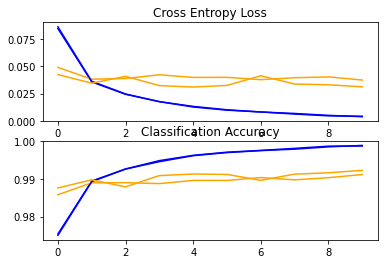

summarize_diagnostics Elapsed time: 0.0 minutes, 0.18 seconds
Accuracy: mean=99.174 std=0.056, n=2


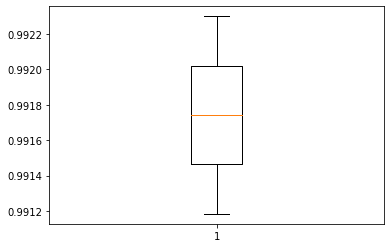

summarize_performance Elapsed time: 0.0 minutes, 0.11 seconds
run_test_harness Elapsed time: 15.0 minutes, 48.40 seconds


In [ ]:
run_test_harness()

Furthermore, I will seek to increase the depth of the feature extractor part of the model, following a VGG-like pattern of adding more convolutional and pooling layers with the same sized filter, while increasing the number of filters. In this case, I'll add a double convolutional layer with 64 filters each, followed by another max pooling layer.

In [12]:
# define cnn model
def define_model():
	model = Sequential()
	model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', input_shape=(28, 28, 1)))
	model.add(MaxPooling2D((2, 2)))
	model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform'))
	model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform'))
	model.add(MaxPooling2D((2, 2)))
	model.add(Flatten())
	model.add(Dense(100, activation='relu', kernel_initializer='he_uniform'))
	model.add(Dense(10, activation='softmax'))
	# compile model
	opt = SGD(learning_rate=0.01, momentum=0.9)
	model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
	return model

load_dataset Elapsed time: 0.0 minutes, 0.01 seconds
prep_pixels Elapsed time: 0.0 minutes, 1.74 seconds
> 99.362
> 99.265
evaluate_model Elapsed time: 43.0 minutes, 15.12 seconds


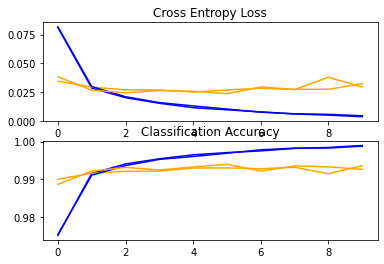

summarize_diagnostics Elapsed time: 0.0 minutes, 0.37 seconds
Accuracy: mean=99.314 std=0.049, n=2


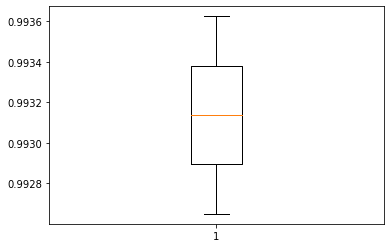

summarize_performance Elapsed time: 0.0 minutes, 0.15 seconds
run_test_harness Elapsed time: 43.0 minutes, 17.46 seconds


In [ ]:
run_test_harness()

## Final Model

Overall, the deeper iteration of the model is the best performer with an mean average accuracy of 99.314 on a k=2 and <> on a k=5.

Therefore, I will use this model to fit and save as a final model. Then, using it's h5 file, I will run it on the test set and get my final results. I believe it is common practice to fit a model on all avaialble data but I will not do that here, holding out the test data for the final evaluation. First, I must actually save the model as an h5 executable.

In [18]:
# fit model using only training data
def run_test_harness():
	trainX, trainY, testX, testY = load_dataset()
	trainX, testX = prep_pixels(trainX, testX)
	model = define_model()
	model.fit(trainX, trainY, epochs=10, batch_size=32, verbose=0)
	# save model
	model.save('final_model.h5')
 
run_test_harness()

Now, if you run this code, there will be a new file in your root directory. Using this, I can evaluate the final model. In order to do this it is easiest yet again to redefine the `run_test_harness()` driver function.

In [24]:
from tensorflow.keras.models import load_model					# type: ignore
from tensorflow.keras.datasets import mnist						# type: ignore

# load train and test dataset
def load_dataset():
	# load dataset
	# reshape dataset to have a single channel
	trainX = X_train.reshape((X_train.shape[0], 28, 28, 1))
	testX = X_test.reshape((X_test.shape[0], 28, 28, 1))
	# one hot encode target values
	trainY = to_categorical(y_train)
	testY = to_categorical(y_test)
	return trainX, trainY, testX, testY
 
# scale pixels
def prep_pixels(train, test):
	# convert from integers to floats
	train_norm = train.astype('float32')
	test_norm = test.astype('float32')
	# normalize to range 0-1
	train_norm = train_norm / 255.0
	test_norm = test_norm / 255.0
	# return normalized images
	return train_norm, test_norm

# run the test harness for evaluating a model
def run_test_harness():
	trainX, trainY, testX, testY = load_dataset()
	trainX, testX = prep_pixels(trainX, testX)
	model = load_model('final_model.h5')
	_, acc = model.evaluate(testX, testY, verbose=0)
	print('> %.3f' % (acc * 100.0))
 
# entry point, run the test harness
run_test_harness()

> 99.512
